In [1]:
import pandas as pd

df = pd.read_csv("../../preprocessing/log공선성제거_Final_data.csv")
df

,Date,GC=F_Volume,^VIX_Volatility,GC=F_Volatility,SHY_Volatility,PER(배),y_target_log
0,2022-11-07,3.761200,0.845868,1.791759,0.039222,29.475254,5.940040
1,2022-11-08,3.178054,1.071584,2.292537,0.067658,29.475254,5.945421
2,2022-11-09,6.210600,0.845868,2.721292,0.131028,29.475254,5.924603
3,2022-11-10,5.786897,1.558145,3.763525,0.122215,29.475254,5.978101
4,2022-11-11,5.552960,0.932164,2.240712,0.104361,29.475254,5.987733
...,...,...,...,...,...,...,...
749,2025-11-03,0.000000,1.040277,4.127134,0.039222,57.209831,6.526993
750,2025-11-04,6.489205,1.275363,4.234107,0.029558,57.209831,6.515068
751,2025-11-05,6.327937,1.311032,4.000036,0.076963,57.209831,6.518528
752,2025-11-06,6.478510,1.300192,3.353410,0.048793,57.209831,6.507740


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


cols = df.columns.tolist()
chunk_size = 10

for i in range(0, len(cols), chunk_size):
    chunk_cols = cols[i:i + chunk_size]
    print("=" * 80)
    print(f"📌 Describe {i+1} ~ {i+len(chunk_cols)} 컬럼")
    print("=" * 80)
    
    # 문자형 포함 모든 컬럼 describe
    print(df[chunk_cols].describe(include='all'))
    print("\n\n")

📌 Describe 1 ~ 7 컬럼
              Date  GC=F_Volume  ^VIX_Volatility  GC=F_Volatility  \
count          754   754.000000       754.000000       754.000000   
unique         754          NaN              NaN              NaN   
top     2025-11-07          NaN              NaN              NaN   
freq             1          NaN              NaN              NaN   
mean           NaN     5.661250         0.908194         2.922204   
std            NaN     1.998898         0.437206         1.002914   
min            NaN     0.000000         0.215112         0.000000   
25%            NaN     4.350216         0.604316         2.476551   
50%            NaN     5.669881         0.837247         3.065722   
75%            NaN     6.804866         1.106907         3.574449   
max            NaN    12.217873         3.769076         5.505333   

        SHY_Volatility      PER(배)  y_target_log  
count       754.000000  754.000000    754.000000  
unique             NaN         NaN           NaN 

- 데이터 정의

In [3]:
import numpy as np

# 로그 데이터 기준 전일 대비 변화율 (차분)
df["ret_prev"] = df["y_target_log"] - df["y_target_log"].shift(1)

# 날짜 설정
df["Date"] = pd.to_datetime(df["Date"])

# 숫자형 + NA 제거
df_num = df.select_dtypes(include=[np.number]).dropna()
dates_num = df.loc[df_num.index, "Date"].reset_index(drop=True)

target_col = "ret_prev"
feature_cols = [c for c in df_num.columns if c not in [target_col, "y_target_log"]]
# print(feature_cols)

X = df_num[feature_cols].values    
y = df_num[[target_col]].values

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (753, 5)
y shape: (753, 1)


- 스케일링

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

- 데이터 분할

In [5]:
n = len(X_scaled)
test_size = int(n * 0.20)
remaining = n - test_size
val_size = int(remaining * 0.20)
train_size = remaining - val_size

X_train_scaled = X_scaled[:train_size]
y_train_scaled = y_scaled[:train_size]

X_val_scaled = X_scaled[train_size : train_size + val_size]
y_val_scaled = y_scaled[train_size : train_size + val_size]

X_test_scaled = X_scaled[train_size + val_size :]
y_test_scaled = y_scaled[train_size + val_size :]

print("분할 결과:", len(X_train_scaled), len(X_val_scaled), len(X_test_scaled))

분할 결과: 483 120 150


- 시계열 데이터셋 생성 함수

In [6]:
## 1-step 예측
def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

- 학습/평가 함수 정의

In [7]:
## 고친 거
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
import random

def train_evaluate_samplewise(X_train_scaled, y_train_scaled,
                              X_val_scaled, y_val_scaled,
                              X_test_scaled=None, y_test_scaled=None,
                              seq_len=5,
                              seed=42,
                              epochs=500,
                              batch_size=64,
                              save_path=None):  ## 베이스라인 best.keras 안 할 거니까

    # 1. 시드 고정
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

    # 2. 시퀀스 생성
    X_seq_train, y_seq_train = create_sequences(X_train_scaled, y_train_scaled, seq_len)
    X_seq_val, y_seq_val    = create_sequences(X_val_scaled, y_val_scaled, seq_len)

    if X_test_scaled is not None and y_test_scaled is not None:
        X_seq_test, y_seq_test = create_sequences(X_test_scaled, y_test_scaled, seq_len)
    else:
        X_seq_test, y_seq_test = None, None

    # 3. LSTM 모델 정의
    model = Sequential([
        LSTM(64, input_shape=(seq_len, X_seq_train.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    
    # 🔥 체크포인트 콜백 (val_loss 개선 시 저장)

    callbacks = []

    if save_path is not None:
        checkpoint = ModelCheckpoint(
            filepath=save_path,
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=False,
            mode='min',
            verbose=0
        )
        callbacks.append(checkpoint)

    # early = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    # callbacks.append(early)

    # 4. 학습
    history = model.fit(
        X_seq_train, y_seq_train,
        validation_data=(X_seq_val, y_seq_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        shuffle=False,
        callbacks=callbacks   ## 최종 모델 best.keras 
    )

    # 5. 지표 계산 함수
    def calc_metrics(y_true, y_pred):
        return {
            "rmse": np.sqrt(mean_squared_error(y_true, y_pred)),
            "mae": mean_absolute_error(y_true, y_pred),
            "r2": r2_score(y_true, y_pred)
        }

    # 샘플별 예측
    def predict_samplewise(X_seq):
        pred_list = []
        for i in range(len(X_seq)):
            x_input = X_seq[i:i+1]
            pred_i = model.predict(x_input, verbose=0)[0, 0]
            pred_list.append(pred_i)
        return np.array(pred_list).reshape(-1, 1)

    # Train/Val 예측
    y_train_pred = predict_samplewise(X_seq_train)
    y_val_pred   = predict_samplewise(X_seq_val)

    # Test 예측 (조건부)
    if X_seq_test is not None:
        y_test_pred  = predict_samplewise(X_seq_test)
        test_metrics = calc_metrics(y_seq_test, y_test_pred)
    else:
        y_test_pred = None
        test_metrics = {"rmse": float('nan'), "mae": float('nan'), "r2": float('nan')}

    # 최종 결과 저장
    metrics = {
        "val_loss": min(history.history['val_loss']),
        "train": calc_metrics(y_seq_train, y_train_pred),
        "val": calc_metrics(y_seq_val, y_val_pred),
        "test": test_metrics,
        "model": model,
        "X_seq_train": X_seq_train,
        "y_seq_train": y_seq_train,
        "X_seq_val": X_seq_val,
        "y_seq_val": y_seq_val,
        "X_seq_test": X_seq_test,
        "y_seq_test": y_seq_test,
        "y_train_pred": y_train_pred,
        "y_val_pred": y_val_pred,
        "y_test_pred": y_test_pred
    }

    return metrics


- 베이스라인

In [8]:
BASELINE_SEQ_LEN = 5

baseline_results = train_evaluate_samplewise(
    X_train_scaled, y_train_scaled,
    X_val_scaled, y_val_scaled,
    X_test_scaled, y_test_scaled,
    seq_len=BASELINE_SEQ_LEN,
    epochs=200,
    batch_size=64,
    save_path=None
)

C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


- 베이스 성능평가

=== LSTM 차분(ret_prev) 성능 ===
RMSE: 0.008804, MAE: 0.006327, R2: -0.182338


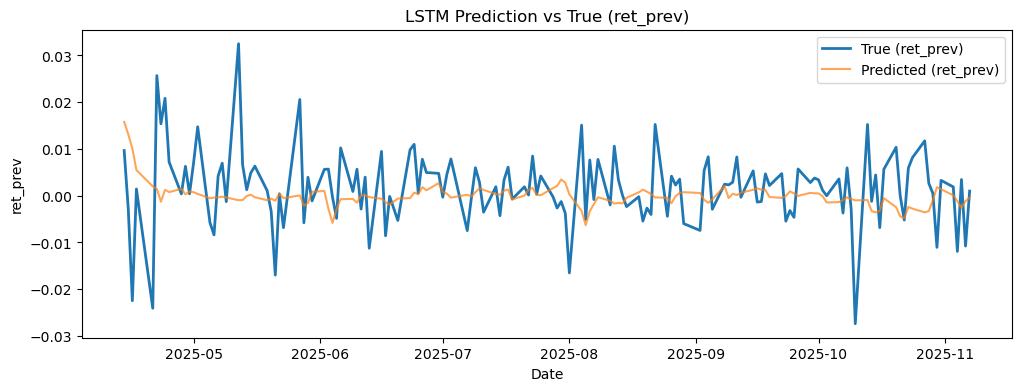


=== LSTM 지수(Level) 복원 성능 ===
Price RMSE : 0.0088, MAE : 0.0063, R2 : 0.9833


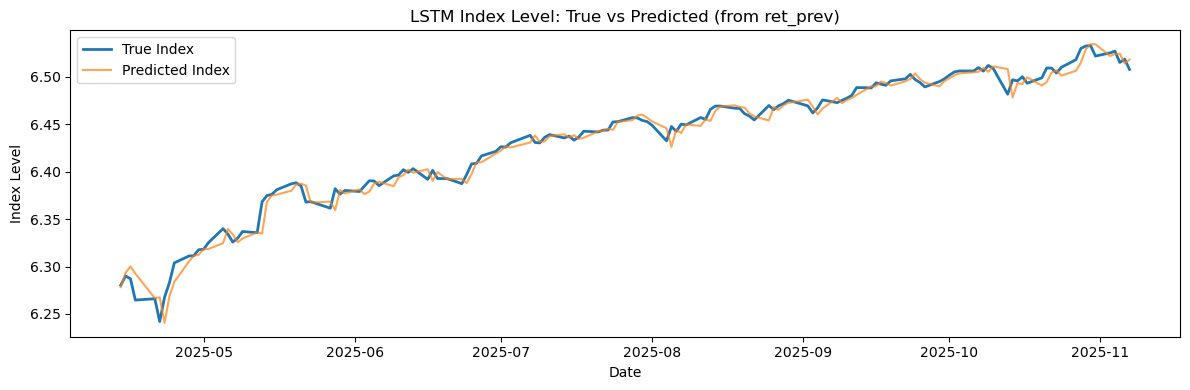

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1️⃣ 차분(ret_prev) 상태 성능 평가

y_test_pred_scaled = baseline_results['y_test_pred']       # 스케일 해제 전 예측
y_test_true_scaled = baseline_results['y_seq_test']        # 스케일 해제 전 실제값

# MinMaxScaler로 원래 스케일 복원
y_test_pred_inv = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_true_inv = scaler_y.inverse_transform(y_test_true_scaled)

# DataFrame 생성
date_test = dates_num.iloc[BASELINE_SEQ_LEN + train_size + val_size : 
                          BASELINE_SEQ_LEN + train_size + val_size + len(y_test_true_inv)].reset_index(drop=True)

result_ret = pd.DataFrame({
    "Date": date_test,
    "y_true_ret": y_test_true_inv.flatten(),
    "y_pred_ret": y_test_pred_inv.flatten()
})

# 지표 계산
rmse_ret = np.sqrt(mean_squared_error(result_ret["y_true_ret"], result_ret["y_pred_ret"]))
mae_ret = mean_absolute_error(result_ret["y_true_ret"], result_ret["y_pred_ret"])
r2_ret = r2_score(result_ret["y_true_ret"], result_ret["y_pred_ret"])

print("=== LSTM 차분(ret_prev) 성능 ===")
print(f"RMSE: {rmse_ret:.6f}, MAE: {mae_ret:.6f}, R2: {r2_ret:.6f}")

# 시각화
plt.figure(figsize=(12,4))
plt.plot(result_ret["Date"], result_ret["y_true_ret"], label="True (ret_prev)", linewidth=2)
plt.plot(result_ret["Date"], result_ret["y_pred_ret"], label="Predicted (ret_prev)", alpha=0.7)
plt.title("LSTM Prediction vs True (ret_prev)")
plt.xlabel("Date")
plt.ylabel("ret_prev")
plt.legend()
plt.show()


# 2️⃣ 차분 → 지수 수준(Level) 복원 후 성능 평가

price_col = "y_target_log"
n_test = len(y_test_true_inv)
start_idx = BASELINE_SEQ_LEN + train_size + val_size
idx_curr_start = start_idx
idx_curr_end = start_idx + n_test

# 실제 지수 P_t
price_true = df[price_col].iloc[idx_curr_start:idx_curr_end].to_numpy()

# 수익률 기준이 되는 "어제 지수" P_{t-1}
price_prev = df[price_col].iloc[idx_curr_start-1 : idx_curr_start-1 + n_test].to_numpy()

# 예측/실제 수익률
ret_true = y_test_true_inv.flatten()
ret_pred = y_test_pred_inv.flatten()

# 지수 수준 복원 (Level)
price_pred_from_ret = price_prev + ret_pred
price_true_from_ret = price_prev + ret_true  # 검증용, 거의 동일해야 함

# DataFrame 생성
result_price = pd.DataFrame({
    "Date": date_test.reset_index(drop=True),
    "Price_true_df": price_true,
    "Price_true_from_ret": price_true_from_ret,
    "Price_pred": price_pred_from_ret
})

# 지표 계산
rmse_price = np.sqrt(mean_squared_error(result_price["Price_true_df"], result_price["Price_pred"]))
mae_price = mean_absolute_error(result_price["Price_true_df"], result_price["Price_pred"])
r2_price = r2_score(result_price["Price_true_df"], result_price["Price_pred"])

print("\n=== LSTM 지수(Level) 복원 성능 ===")
print(f"Price RMSE : {rmse_price:.4f}, MAE : {mae_price:.4f}, R2 : {r2_price:.4f}")

# 시각화
plt.figure(figsize=(12,4))
plt.plot(result_price["Date"], result_price["Price_true_df"], label="True Index", linewidth=2)
plt.plot(result_price["Date"], result_price["Price_pred"], label="Predicted Index", alpha=0.7)
plt.title("LSTM Index Level: True vs Predicted (from ret_prev)")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.legend()
plt.tight_layout()
plt.show()

- 최적 seq_len찾기 (1~50까지 200으로 찾아서 거기서 나온 best로 500 ㄲ)

In [10]:
seq_len_candidates = list(range(1, 51))
best_val_loss = float('inf')
best_seq_len = None
# best_results = None

# 1. 1차 탐색: epochs 200으로 대략적 최적 seq_len 찾기
for seq_len in seq_len_candidates:
    results = train_evaluate_samplewise(
        X_train_scaled, y_train_scaled,
        X_val_scaled, y_val_scaled,
        X_test_scaled = None, y_test_scaled = None,   ## 데이터 오염 및 객관성 상실 위험
        seq_len=seq_len,
        epochs=200,
        batch_size=64
    )

    val_loss = results["val_loss"]

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_seq_len = seq_len
    
    print(f"seq_len={seq_len:2d} | val_loss={val_loss:.6f}")

print(f"\n 1차 탐색 완료 → 최적 seq_len={best_seq_len}, 최저 val_loss={best_val_loss:.6f}")

C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len= 1 | val_loss=0.005391


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len= 2 | val_loss=0.005370


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len= 3 | val_loss=0.005333


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len= 4 | val_loss=0.005350


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len= 5 | val_loss=0.005346


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len= 6 | val_loss=0.005552


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len= 7 | val_loss=0.005567


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len= 8 | val_loss=0.005476


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len= 9 | val_loss=0.005496


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=10 | val_loss=0.005491


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=11 | val_loss=0.005536


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=12 | val_loss=0.005583


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=13 | val_loss=0.005636


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=14 | val_loss=0.005662


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=15 | val_loss=0.005484


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=16 | val_loss=0.005492


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=17 | val_loss=0.005559
seq_len=18 | val_loss=0.005668


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=19 | val_loss=0.005576


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=20 | val_loss=0.005644


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=21 | val_loss=0.005609


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=22 | val_loss=0.005639


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=23 | val_loss=0.005659


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=24 | val_loss=0.005748


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=25 | val_loss=0.005818


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=26 | val_loss=0.005799


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=27 | val_loss=0.005857


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=28 | val_loss=0.005961


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=29 | val_loss=0.006015


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=30 | val_loss=0.006052


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=31 | val_loss=0.005984


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=32 | val_loss=0.006162


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=33 | val_loss=0.006295


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=34 | val_loss=0.006240


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=35 | val_loss=0.006255


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=36 | val_loss=0.006333


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=37 | val_loss=0.006418


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=38 | val_loss=0.006412


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=39 | val_loss=0.006493


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=40 | val_loss=0.006591


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=41 | val_loss=0.006709


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=42 | val_loss=0.006734


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=43 | val_loss=0.006794


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=44 | val_loss=0.006938


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=45 | val_loss=0.007006


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=46 | val_loss=0.007086


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=47 | val_loss=0.007233


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=48 | val_loss=0.006840


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=49 | val_loss=0.006921


C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


seq_len=50 | val_loss=0.006959

 1차 탐색 완료 → 최적 seq_len=3, 최저 val_loss=0.005333


In [11]:
# 2. 최적 seq_len로 최종 학습 (epochs 500) - Test 데이터 포함
# 이 부분은 for 루프 바깥에서 실행됩니다.
best_model_path = "../../modeling/Model/LSTM_best.keras"


best_results = train_evaluate_samplewise(
    X_train_scaled, y_train_scaled,
    X_val_scaled, y_val_scaled,
    X_test_scaled, y_test_scaled, # Test 데이터를 포함하여 최종 성능 측정
    seq_len=best_seq_len,
    epochs=500,
    batch_size=64,
    save_path=best_model_path
)

# 최종 지표 출력
print("\n최종 학습 결과:")
print(f"최적 시퀀스 길이: {best_seq_len}")

C:\Users\ssginc10\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



최종 학습 결과:
최적 시퀀스 길이: 3


=== 최적 seq_len LSTM 차분(ret_prev) 성능 ===
RMSE: 0.010288, MAE: 0.006764, R2: -0.306374


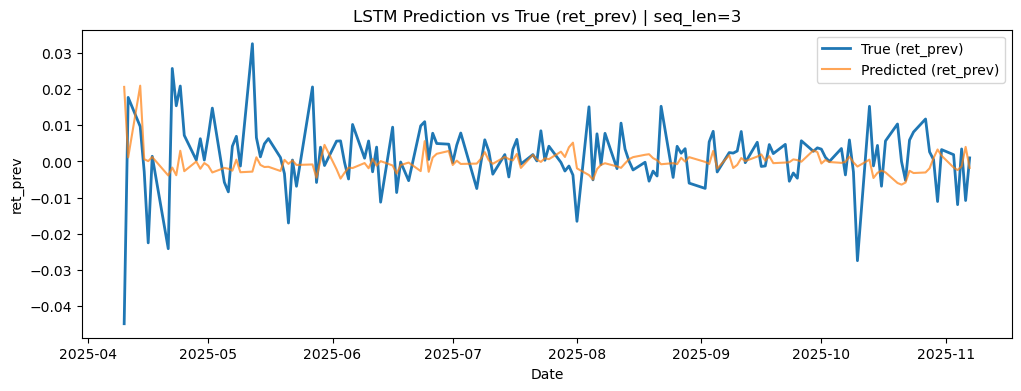


=== 최적 seq_len LSTM 지수(Level) 복원 성능 ===
RMSE : 0.0116, MAE : 0.0071, R2 : 0.9725


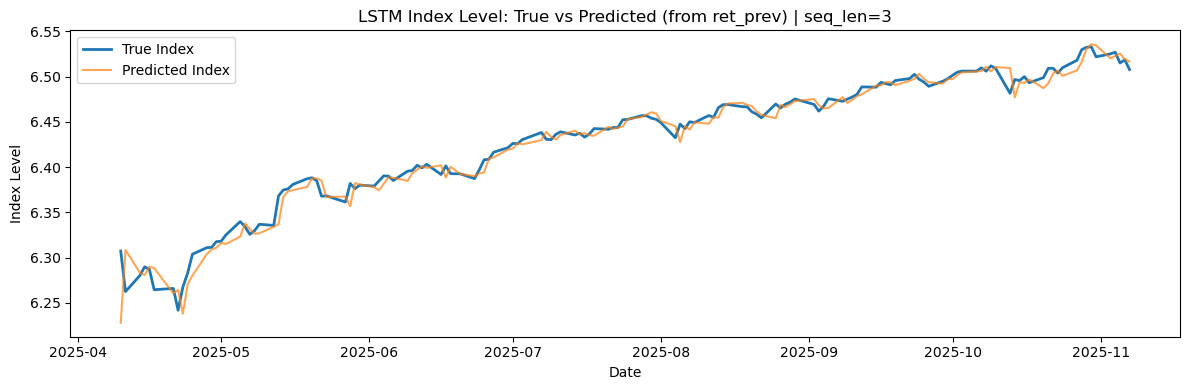

In [14]:
# 1️⃣ 차분(ret_prev) 상태 성능 평가

y_test_pred_scaled = best_results['y_test_pred']       # 스케일 해제 전 예측
y_test_true_scaled = best_results['y_seq_test']        # 스케일 해제 전 실제값

# MinMaxScaler로 원래 스케일 복원
y_test_pred_inv = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_true_inv = scaler_y.inverse_transform(y_test_true_scaled)

# date_test 생성 시 seq_len 맞추기
date_test = dates_num.iloc[train_size + val_size + best_seq_len : 
                          train_size + val_size + best_seq_len + len(y_test_true_inv)].reset_index(drop=True)

# DataFrame 생성
result_ret = pd.DataFrame({
    "Date": date_test,
    "y_true_ret": y_test_true_inv.flatten(),
    "y_pred_ret": y_test_pred_inv.flatten()
})

# 지표 계산
rmse_ret = np.sqrt(mean_squared_error(result_ret["y_true_ret"], result_ret["y_pred_ret"]))
mae_ret = mean_absolute_error(result_ret["y_true_ret"], result_ret["y_pred_ret"])
r2_ret = r2_score(result_ret["y_true_ret"], result_ret["y_pred_ret"])

print("=== 최적 seq_len LSTM 차분(ret_prev) 성능 ===")
print(f"RMSE: {rmse_ret:.6f}, MAE: {mae_ret:.6f}, R2: {r2_ret:.6f}")

# 시각화
plt.figure(figsize=(12,4))
plt.plot(result_ret["Date"], result_ret["y_true_ret"], label="True (ret_prev)", linewidth=2)
plt.plot(result_ret["Date"], result_ret["y_pred_ret"], label="Predicted (ret_prev)", alpha=0.7)
plt.title(f"LSTM Prediction vs True (ret_prev) | seq_len={best_seq_len}")
plt.xlabel("Date")
plt.ylabel("ret_prev")
plt.legend()
plt.show()


# 2️⃣ 차분 → 지수 수준(Level) 복원 후 성능 평가

price_col = "y_target_log"
n_test = len(y_test_true_inv)
start_idx = train_size + val_size + best_seq_len
idx_curr_start = start_idx
idx_curr_end = start_idx + n_test

# 실제 지수 P_t
price_true = df[price_col].iloc[idx_curr_start:idx_curr_end].to_numpy()

# 수익률 기준이 되는 "어제 지수" P_{t-1}
price_prev = df[price_col].iloc[idx_curr_start-1 : idx_curr_start-1 + n_test].to_numpy()

# 예측/실제 수익률
ret_true = y_test_true_inv.flatten()
ret_pred = y_test_pred_inv.flatten()

# 지수 수준 복원 (Level)
price_pred_from_ret = price_prev + ret_pred
price_true_from_ret = price_prev + ret_true  # 검증용

# DataFrame 생성
result_price = pd.DataFrame({
    "Date": date_test,
    "Price_true_df": price_true,
    "Price_true_from_ret": price_true_from_ret,
    "Price_pred": price_pred_from_ret
})

# 지표 계산
rmse_price = np.sqrt(mean_squared_error(result_price["Price_true_df"], result_price["Price_pred"]))
mae_price = mean_absolute_error(result_price["Price_true_df"], result_price["Price_pred"])
r2_price = r2_score(result_price["Price_true_df"], result_price["Price_pred"])

print("\n=== 최적 seq_len LSTM 지수(Level) 복원 성능 ===")
print(f"RMSE : {rmse_price:.4f}, MAE : {mae_price:.4f}, R2 : {r2_price:.4f}")

# 시각화
plt.figure(figsize=(12,4))
plt.plot(result_price["Date"], result_price["Price_true_df"], label="True Index", linewidth=2)
plt.plot(result_price["Date"], result_price["Price_pred"], label="Predicted Index", alpha=0.7)
plt.title(f"LSTM Index Level: True vs Predicted (from ret_prev) | seq_len={best_seq_len}")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
metrics_df = pd.DataFrame({
    "Top60_LSTM_RMSE": [rmse_price],
    "Top60_LSTM_MAE": [mae_price],
    "Top60_LSTM_R2": [r2_price]
})

# 2) CSV로 저장
metrics_df.to_csv("../../modeling/성능지표/Top60_LSTM_지표.csv", index=False, encoding="utf-8-sig")
print("CSV 저장 완료: SPY_log_LSTM_지표.csv")

CSV 저장 완료: SPY_log_LSTM_지표.csv
